In [1]:
# DecisionTreeClassifier and PCA

# increase the width of the notebook
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

y_train = train["Score"]
y_test = test["Score"]

X_train = train.drop("Score", axis=1)
X_test = test.drop("Score", axis=1)


## Transformations

In [4]:
# Preprocessing pipelines
numeric_features = ["WhiteElo", "EloDif"]
categorical_features = ["Opening_name", "Time_format", "Increment_binary"]

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

## DecisionTree and GridSearch using pipeline

In [5]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)

dt_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", dt)
])

param_grid = {
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(dt_pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy: {:.3f}".format(grid_search.best_score_))

Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best CV accuracy: 0.537


In [6]:
# Evaluate on test set
y_pred = grid_search.predict(X_test)
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

best_tree = grid_search.best_estimator_
joblib.dump(best_tree, 'best_decision_tree.joblib')

Test set accuracy: 0.527

Classification Report:
               precision    recall  f1-score   support

   Black Win       0.52      0.40      0.45      4524
        Draw       0.00      0.00      0.00       566
   White Win       0.53      0.70      0.61      4910

    accuracy                           0.53     10000
   macro avg       0.35      0.37      0.35     10000
weighted avg       0.50      0.53      0.50     10000



['best_decision_tree.joblib']

### Tree visualization

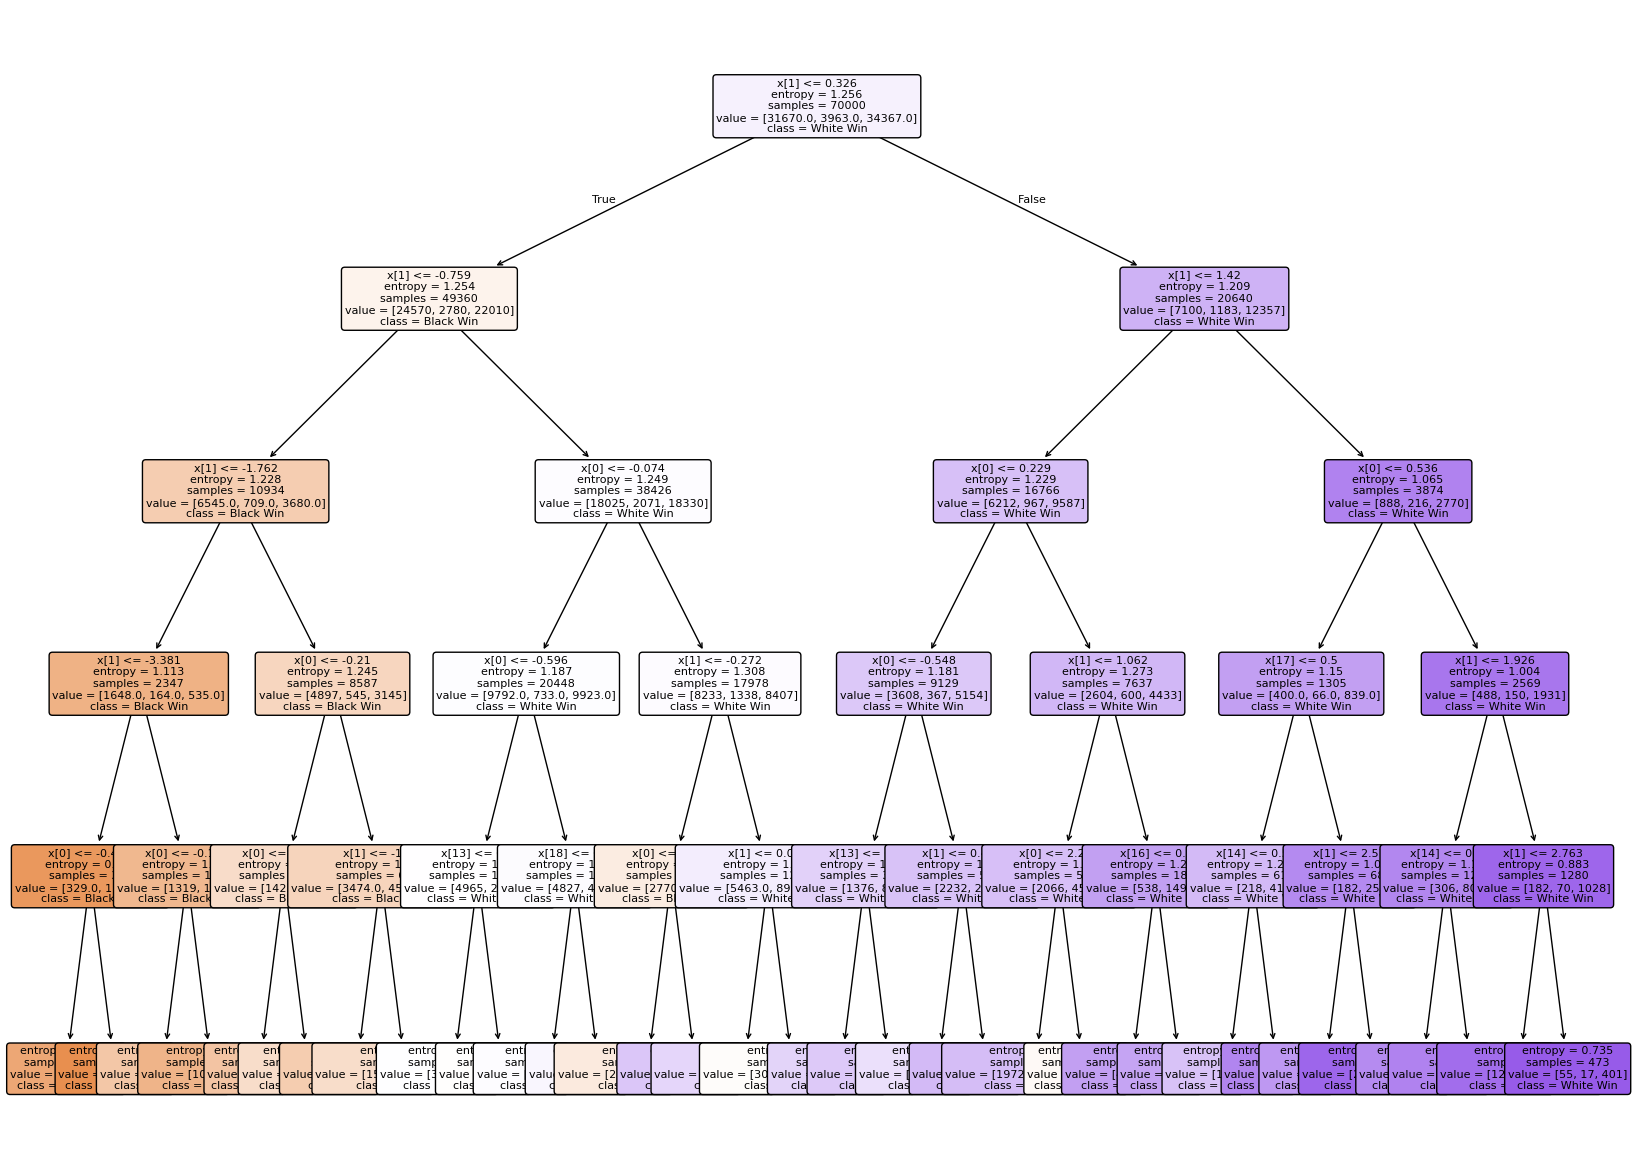

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

best_tree_model = best_tree.named_steps["classifier"]
class_names = best_tree.named_steps["classifier"].classes_

plt.figure(figsize=(20, 15))
plot_tree(
    best_tree_model,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()

## Principal Component Analysis (PCA) 

In [8]:
from sklearn.decomposition import PCA

# Fit preprocessor on training data only
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)

X_train_dense = X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
X_test_dense  = X_test_transformed.toarray()  if hasattr(X_test_transformed, "toarray")  else X_test_transformed

pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca  = pca.transform(X_test_dense)

print(f"Original feature count: {X_train_dense.shape[1]}")
print(f"Reduced feature count:  {X_train_pca.shape[1]} (90% variance)")

Original feature count: 19
Reduced feature count:  8 (90% variance)


In [9]:
# Train decision tree on PCA data
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_pca = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_pca.fit(X_train_pca, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [10]:
print("Best parameters (PCA + Tree):", grid_search_pca.best_params_)
print("Best CV accuracy (PCA + Tree): {:.3f}".format(grid_search_pca.best_score_))

y_pred_pca = grid_search_pca.predict(X_test_pca)
print("Test accuracy (PCA + Tree): {:.3f}".format(accuracy_score(y_test, y_pred_pca)))
print("\nClassification Report (PCA + Tree):\n", classification_report(y_test, y_pred_pca))

best_tree_pca = grid_search_pca.best_estimator_
joblib.dump(best_tree_pca, 'best_decision_tree_pca.joblib')


Best parameters (PCA + Tree): {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy (PCA + Tree): 0.536
Test accuracy (PCA + Tree): 0.532

Classification Report (PCA + Tree):
               precision    recall  f1-score   support

   Black Win       0.53      0.39      0.45      4524
        Draw       0.00      0.00      0.00       566
   White Win       0.53      0.72      0.61      4910

    accuracy                           0.53     10000
   macro avg       0.36      0.37      0.35     10000
weighted avg       0.50      0.53      0.50     10000



['best_decision_tree_pca.joblib']

### Applying PCA did not significantly improve our model's accuracy. The resulting score of 0.532 is very close to the performance of a dummy classifier, whereas the original tree classifier achieved a score of 0.527.